## 构建电商用户画像

### 1. 导入库

参数说明如下。

%matplotlib inline：一个魔法函数，由于%matplotlib inline的存在，当输入plt.plot()后，不必再输入plt.show()，图像将自动显示出来。

datetime：用来显示时间的模块。

In [96]:
# 导入所需的库
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

### 2. 数据准备

此处使用Pandas的read_csv方法读取数据文件，由于数据集太大，为了提高运行效率，使用sample函数随机抽取20%的数据。

DataFrame.sample()是Pandas中的函数，DataFrame是一种数据格式，代指df_orginal。frac(fraction)是抽取多少数据，random_state是随机数种子，目的是保证每次随机抽取的数据一样，防止执行命令时使用不一样的数据。

In [97]:
# 导入数据集
df_orginal = pd.read_csv('./taobao_persona.csv')
# 抽取部分数据
df = df_orginal.sample(frac=0.2,random_state=None)

### 3. 数据预处理

In [98]:
# 查看其中是否有缺失值，统计各字段缺失值
df.isnull().any().sum()
# 发现只有user_geohash有缺失值，且缺失的比例很高，无统计分析的意义，将此列删除
df.drop('user_geohash',axis=1,inplace=True)
# 将time字段拆分为日期和时段
df['date'] = df['time'].str[0:10]
df['time'] = df['time'].str[11:]
df['time'] = df['time'].astype(int)
# date用str方法取0-9位的字符，time取11位到最后一位，将time转化成int类型。
# 将时段分为'凌晨','上午','中午','下午','晚上'
df['hour'] = pd.cut(df['time'],bins=[-1,5,10,13,18,24],labels=['凌晨','上午','中午','下午','晚上'])

In [99]:
# 生成用户标签表，制作好的标签都加入这个表中
users = df['user_id'].unique()
labels = pd.DataFrame(users,columns=['user_id'])

In [100]:
#之后分析后的内容都会放置在此表中，相当于建立了一个空白表，将自己分析后的结论一一加入。
labels 

,user_id
0,32363170
1,141137969
2,43531769
3,49776801
4,128031111
...,...
19942,16783114
19943,135594252
19944,139786090
19945,108201638


### 4. 构建用户行为标签

#### 4.1 对用户浏览时间段进行分析

选取出各用户浏览次数最多的时段，看看用户到底在什么时间浏览商品比较多。

In [101]:
# 对用户和时段分组，统计浏览次数
time_browse = df[df['behavior_type']==1].groupby(['user_id','hour']).item_id.count().reset_index()
time_browse.rename(columns={'item_id':'hour_counts'},inplace=True)
# 统计每个用户浏览次数最多的时段
time_browse_max = time_browse.groupby('user_id').hour_counts.max().reset_index()
time_browse_max.rename(columns={'hour_counts':'read_counts_max'},inplace=True)
time_browse = pd.merge(time_browse,time_browse_max,how='left',on='user_id')
# 之前已经按照user_id和hour进行了浏览物品次数的计数统计，现在借用浏览次数统计user_id在
# 哪个时间段浏览次数最多，并将其作为该用户的浏览时间标签的代表。
# 选取各用户浏览次数最多的时段，如有并列最多的时段，用逗号连接
time_browse_hour=time_browse.loc[time_browse['hour_counts']==time_browse['read_counts_max'],'hour'].groupby(time_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()
time_browse_hour.head()
# 将用户浏览活跃时间段加入用户标签表中
labels = pd.merge(labels,time_browse_hour,how='left',on='user_id')
labels.rename(columns={'hour':'time_browse'},inplace=True)
# labels相当于一张考试卷纸，上面展示的都是最后处理好的结

In [102]:
labels

,user_id,time_browse
0,32363170,凌晨
1,141137969,凌晨
2,43531769,晚上
3,49776801,晚上
4,128031111,晚上
...,...,...
19942,16783114,中午
19943,135594252,晚上
19944,139786090,下午
19945,108201638,晚上


groupby(['key1','key2'])：多列聚合，分组键为列名。

reset_index()：默认drop=False，可以获得新的index，原来的index变成数据列保留下来，第一列会添加计数的数字，不会使用数据中的index。

rename()：进行重命名，此处将item_id替换成hour_counts，inplace为是否原地填充。

pd.merge()：将两个表合并在一起，横向合并，on代表通过某个主键，how指左合并，每行一一对应。

loc函数：通过行索引Index中的具体值来取指定数据。

aggregate函数：groupby分组之后会返回多个子数据帧，该函数可以实现数据聚合，可以得到每个子数据帧的某些列的某些信息。

lambda函数：可以定义一个匿名函数，lambda [arg1[, arg2, … argN]]: expression，其中参数是函数的输入，是可选的，后面的表达式则为输出，此处和join()函数一起用，其中每个x值能被“,”隔开;使用类似的代码可以生成浏览活跃时间段，此处就不再赘述。

#### 4.2 关于类目的用户行为

In [103]:
df_browse = df.loc[df['behavior_type']==1,['user_id','item_id','item_category']]
df_collect = df.loc[df['behavior_type']==2,['user_id','item_id','item_category']]
df_cart = df.loc[df['behavior_type']==3,['user_id','item_id','item_category']]
df_buy = df.loc[df['behavior_type']==4,['user_id','item_id','item_category']]

根据不同的用户行为，如浏览、收藏等，分别导出数据进行分析。

In [104]:
 # 对用户与类目进行分组，统计浏览次数
df_cate_most_browse = df_browse.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_browse.rename(columns={'item_id':'item_category_counts'},inplace=True)
# 统计每个用户浏览次数最多的类目
df_cate_most_browse_max=df_cate_most_browse.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_browse_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_browse = pd.merge(df_cate_most_browse,df_cate_most_browse_max,how='left',on='user_id')
# 将item_category的数字类型改为字符串型
df_cate_most_browse['item_category'] = df_cate_most_browse['item_category'].astype(str)
# 选取各用户浏览次数最多的类目，如有并列最多的类目，用逗号连接
df_cate_browse=df_cate_most_browse.loc[df_cate_most_browse['item_category_counts']==df_cate_most_browse['item_category_counts_max'],'item_category'].groupby(df_cate_most_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()
# 将用户浏览最多的类目加入用户标签表中
labels = pd.merge(labels,df_cate_browse,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_browse'},inplace=True)
labels.head(5)

,user_id,time_browse,cate_most_browse
0,32363170,凌晨,13230
1,141137969,凌晨,11279
2,43531769,晚上,10314
3,49776801,晚上,1863
4,128031111,晚上,11279


从整理的数据中可以看出，浏览、加购物车、收藏、购买之前其实不一定存在明显的必然关系，我们还需要进一步分析得到一些规律。

#### 4.3 近30天用户行为分析

近30天购买次数

In [105]:
#将购买行为按用户进行分组，统计次数
df_counts_30_buy = df[df['behavior_type']==4].groupby('user_id').item_id.count().reset_index()
labels = pd.merge(labels,df_counts_30_buy,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_30_buy'},inplace=True)

近30天加购次数

In [106]:
# 将加购行为按用户进行分组，统计次数
df_counts_30_cart = df[df['behavior_type']==3].groupby('user_id').item_id.count().reset_index()
labels = pd.merge(labels,df_counts_30_cart,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_30_cart'},inplace=True)

近30天活跃天数

In [107]:
# 对用户进行分组，统计活跃的天数，包括浏览、收藏、加购、购买
counts_30_active = df.groupby('user_id')['date'].nunique()
labels = pd.merge(labels,counts_30_active,how='left',on='user_id')
labels.rename(columns={'date':'counts_30_active'},inplace=True)
#这里pd.nunique()是指返回的是唯一值的个数。

In [108]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active
0,32363170,凌晨,13230,1.0,90.0,31
1,141137969,凌晨,11279,14.0,11.0,24
2,43531769,晚上,10314,1.0,5.0,30
3,49776801,晚上,1863,57.0,20.0,26
4,128031111,晚上,11279,2.0,NaN,27
...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1
19943,135594252,晚上,8161,NaN,NaN,1
19944,139786090,下午,12553,NaN,NaN,1
19945,108201638,晚上,6648,NaN,NaN,1


近30天用户行为分析属于中长期的用户行为，我们可以依此判断是否需要调整营销策略，类似可以得到短期的7天用户行为分析，观察中短期或一个小周期内，用户的行为是何种情况。

#### 4.4 最后一次行为距今天数

分析上次和本次用户行为的时间差值可以实现精确推荐分析，下面我们来看看具体如何实现。

上次浏览距今天数：

In [109]:
df['date'] = pd.to_datetime(df['date'])  
days_browse = df[df['behavior_type']==1].groupby('user_id')['date'].max().apply(
    lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x)
    .days
    )

labels = pd.merge(labels,days_browse,how='left',on='user_id')
labels.rename(columns={'date':'days_browse'},inplace=True)

In [110]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active,days_browse
0,32363170,凌晨,13230,1.0,90.0,31,1.0
1,141137969,凌晨,11279,14.0,11.0,24,1.0
2,43531769,晚上,10314,1.0,5.0,30,1.0
3,49776801,晚上,1863,57.0,20.0,26,1.0
4,128031111,晚上,11279,2.0,NaN,27,1.0
...,...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1,19.0
19943,135594252,晚上,8161,NaN,NaN,1,24.0
19944,139786090,下午,12553,NaN,NaN,1,23.0
19945,108201638,晚上,6648,NaN,NaN,1,3.0


最后一次购买距今天数：

In [111]:
days_buy = df[df['behavior_type']==4].groupby('user_id')['date'].max().apply(
    lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x)
    .days
    )

labels = pd.merge(labels,days_buy,how='left',on='user_id')
labels.rename(columns={'date':'days_buy'},inplace=True)

In [112]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active,days_browse,days_buy
0,32363170,凌晨,13230,1.0,90.0,31,1.0,31.0
1,141137969,凌晨,11279,14.0,11.0,24,1.0,1.0
2,43531769,晚上,10314,1.0,5.0,30,1.0,17.0
3,49776801,晚上,1863,57.0,20.0,26,1.0,2.0
4,128031111,晚上,11279,2.0,NaN,27,1.0,11.0
...,...,...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1,19.0,NaN
19943,135594252,晚上,8161,NaN,NaN,1,24.0,NaN
19944,139786090,下午,12553,NaN,NaN,1,23.0,NaN
19945,108201638,晚上,6648,NaN,NaN,1,3.0,NaN


datetime.strptime('2014-12-19','%Y-%m-%d')-x).days：该部分属于lambda中的函数表达式部分，即计算规则，此处最后取相减后的天数总和。

apply()：格式为apply(func,*args,**kwargs)，当一个函数的参数存在于一个元组或者一个字典中时，可间接调用这个函数，并将元组或者字典中的参数按照顺序传递给该函数，返回值就是func函数的返回值。相当于循环遍历，起到处理每一条数据的效果。

类似可以生成上次加购、购买距今天数，分析得到用户的活跃情况，如图所示，如果长时间没有活跃，则需要推送一些内容，或者发放优惠券刺激用户。



#### 4.5 最近两次购买的间隔天数

In [113]:
df_interval_buy = df[df['behavior_type']==4].groupby(['user_id','date']).item_id.count().reset_index()
interval_buy = df_interval_buy.groupby('user_id')['date'].apply(lambda x:x.sort_values().diff(1).dropna().head(1)).reset_index()
interval_buy['date'] = interval_buy['date'].apply(lambda x : x.days)
interval_buy.drop('level_1',axis=1,inplace=True)
interval_buy.rename(columns={'date':'interval_buy'},inplace=True)
labels = pd.merge(labels,interval_buy,how='left',on='user_id')

In [114]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active,days_browse,days_buy,interval_buy
0,32363170,凌晨,13230,1.0,90.0,31,1.0,31.0,NaN
1,141137969,凌晨,11279,14.0,11.0,24,1.0,1.0,7.0
2,43531769,晚上,10314,1.0,5.0,30,1.0,17.0,NaN
3,49776801,晚上,1863,57.0,20.0,26,1.0,2.0,2.0
4,128031111,晚上,11279,2.0,NaN,27,1.0,11.0,8.0
...,...,...,...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1,19.0,NaN,NaN
19943,135594252,晚上,8161,NaN,NaN,1,24.0,NaN,NaN
19944,139786090,下午,12553,NaN,NaN,1,23.0,NaN,NaN
19945,108201638,晚上,6648,NaN,NaN,1,3.0,NaN,NaN


用购买间隔数分析用户的购买频率，方便确定用户的消费活跃等级，精准制定营销方式。

#### 4.6  是否浏览未下单

In [115]:
df_browse_buy=df.loc[(df['behavior_type']==1)|(df['behavior_type']==4),['user_id','item_id','behavior_type','time']]
browse_not_buy=pd.pivot_table(df_browse_buy,index=['user_id','item_id'],
columns=['behavior_type'],values=['time'],aggfunc=['count'])
browse_not_buy.columns = ['browse','buy']
browse_not_buy.fillna(0,inplace=True)
# 添加了一列browse_not_buy，初始值为0。
browse_not_buy['browse_not_buy'] = 0
# 浏览数>0,购买数=0的数据输出1.
browse_not_buy.loc[(browse_not_buy['browse']>0) & (browse_not_buy['buy']==0),'browse_not_buy'] = 1
browse_not_buy=browse_not_buy.groupby('user_id')['browse_not_buy'].sum().reset_index()
labels = pd.merge(labels,browse_not_buy,how='left',on='user_id')
labels['browse_not_buy'] = labels['browse_not_buy'].apply(lambda x: '是' if x>0 else '否')

|：在Python语句中表示或，&表示且。

pd.pivot_table()：透视表功能，df_browse_buy为data块，values可以对需要的计算数据进行筛选，aggfunc参数可以设置我们对数据聚合时进行的函数操作。

fillna：会填充NaN数据，返回填充后的结果，inplace=True代表原地填充。

In [116]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active,days_browse,days_buy,interval_buy,browse_not_buy
0,32363170,凌晨,13230,1.0,90.0,31,1.0,31.0,NaN,是
1,141137969,凌晨,11279,14.0,11.0,24,1.0,1.0,7.0,是
2,43531769,晚上,10314,1.0,5.0,30,1.0,17.0,NaN,是
3,49776801,晚上,1863,57.0,20.0,26,1.0,2.0,2.0,是
4,128031111,晚上,11279,2.0,NaN,27,1.0,11.0,8.0,是
...,...,...,...,...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1,19.0,NaN,NaN,是
19943,135594252,晚上,8161,NaN,NaN,1,24.0,NaN,NaN,是
19944,139786090,下午,12553,NaN,NaN,1,23.0,NaN,NaN,是
19945,108201638,晚上,6648,NaN,NaN,1,3.0,NaN,NaN,是


针对浏览未下单的用户要加大推广力度，可以增加优惠券的发放次数，促进购物。

#### 4.7 是否加购未下单

In [117]:
df_cart_buy=df.loc[(df['behavior_type']==3)|(df['behavior_type']==4),['user_id','item_id','behavior_type','time']]
cart_not_buy=pd.pivot_table(df_cart_buy,index=['user_id','item_id'],columns=['behavior_type'],values=['time'],aggfunc=['count'])
cart_not_buy.columns = ['cart','buy']
cart_not_buy.fillna(0,inplace=True)
cart_not_buy['cart_not_buy'] = 0
cart_not_buy.loc[(cart_not_buy['cart']>0) & (cart_not_buy['buy']==0),'cart_not_buy'] = 1
cart_not_buy = cart_not_buy.groupby('user_id')['cart_not_buy'].sum().reset_index()
labels = pd.merge(labels,cart_not_buy,how='left',on='user_id')
labels['cart_not_buy'] = labels['cart_not_buy'].apply(lambda x: '是' if x>0 else '否')

In [118]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active,days_browse,days_buy,interval_buy,browse_not_buy,cart_not_buy
0,32363170,凌晨,13230,1.0,90.0,31,1.0,31.0,NaN,是,是
1,141137969,凌晨,11279,14.0,11.0,24,1.0,1.0,7.0,是,是
2,43531769,晚上,10314,1.0,5.0,30,1.0,17.0,NaN,是,是
3,49776801,晚上,1863,57.0,20.0,26,1.0,2.0,2.0,是,是
4,128031111,晚上,11279,2.0,NaN,27,1.0,11.0,8.0,是,否
...,...,...,...,...,...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1,19.0,NaN,NaN,是,否
19943,135594252,晚上,8161,NaN,NaN,1,24.0,NaN,NaN,是,否
19944,139786090,下午,12553,NaN,NaN,1,23.0,NaN,NaN,是,否
19945,108201638,晚上,6648,NaN,NaN,1,3.0,NaN,NaN,是,否


制定营销策略时，要重点注意这部分人群，因为加购未下单的购买转化率是最大的，有成功下单、最大潜力的客户就在这里。

### 5. 构建用户标签

#### 5.1 是否复购用户：

In [119]:
buy_again = df[df['behavior_type']==4].groupby('user_id')['item_id'].count().reset_index()
buy_again.rename(columns={'item_id':'buy_again'},inplace=True)
labels = pd.merge(labels,buy_again,how='left',on='user_id')
labels['buy_again'].fillna(-1,inplace=True)
# 未购买的用户标记为'未购买'，有购买未复购的用户标记为'否'，有复购的用户标记为'是'
labels['buy_again'] = labels['buy_again'].apply(lambda x: '是' if x>1 else  '否' if x==1 else '未购买')

In [120]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active,days_browse,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again
0,32363170,凌晨,13230,1.0,90.0,31,1.0,31.0,NaN,是,是,否
1,141137969,凌晨,11279,14.0,11.0,24,1.0,1.0,7.0,是,是,是
2,43531769,晚上,10314,1.0,5.0,30,1.0,17.0,NaN,是,是,否
3,49776801,晚上,1863,57.0,20.0,26,1.0,2.0,2.0,是,是,是
4,128031111,晚上,11279,2.0,NaN,27,1.0,11.0,8.0,是,否,是
...,...,...,...,...,...,...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1,19.0,NaN,NaN,是,否,未购买
19943,135594252,晚上,8161,NaN,NaN,1,24.0,NaN,NaN,是,否,未购买
19944,139786090,下午,12553,NaN,NaN,1,23.0,NaN,NaN,是,否,未购买
19945,108201638,晚上,6648,NaN,NaN,1,3.0,NaN,NaN,是,否,未购买


#### 5.2 访问活跃度

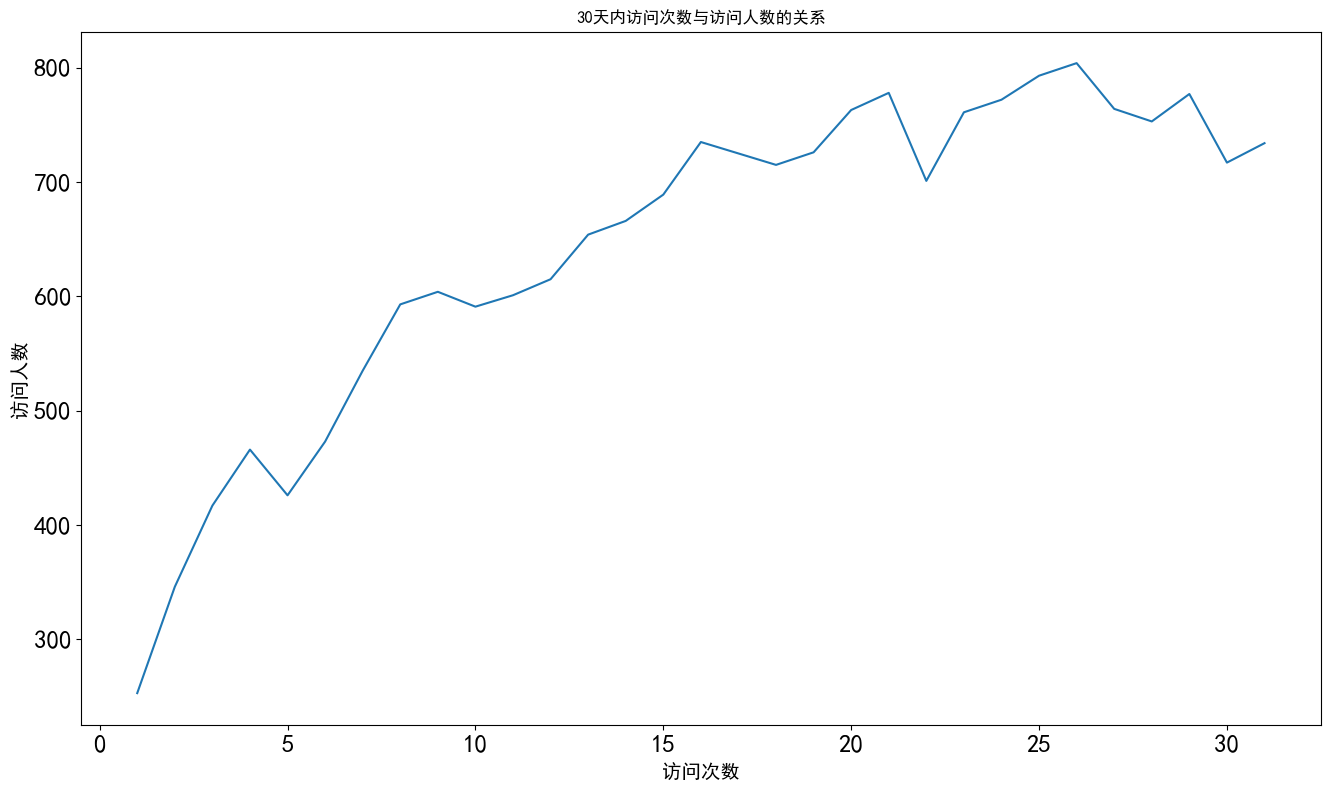

In [121]:
user_active_level = labels['counts_30_active'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16,9))
user_active_level.plot(title='30天内访问次数与访问人数的关系',fontsize=18)
plt.ylabel('访问人数',fontsize=14)
plt.xlabel('访问次数',fontsize=14)
# 用于显示中文
plt.rcParams["font.sans-serif"] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 先将user_active_level全部设置成高，再搜索数值<16的部分，设置成低
labels['user_active_level'] = '高'
labels.loc[labels['counts_30_active']<=16,'user_active_level'] = '低'

value_counts()：查看表格某列中有多少个不同值，并计算每个不同值在该列中有多少重复值。

sort_index()：按照某一列的大小进行排序，ascending=False是按照从大到小排序。

plt.figure(figsize=(a,b))：创建画板，figsize代表宽为a，高为b的图形，单位为英寸。

plt.ylabel：设置y轴，fontsize是字体大小。
plt.xlabel：设置x轴。

通过图可以看出，访问次数多的用户比访问次数少的用户数量多，且以15次左右为拐点，因此定义访问次数小于等于16次的用户为低活跃用户，访问次数大于16次的用户定义为高活跃用户，此定义只是从用户的角度出发，工作中当从业务角度定义。访问次数多的访客比访问次数少的访客数量多，与绝大多数的产品访问规律相反，从侧面反映了用户黏性之强。

#### 5.3 购买活跃度

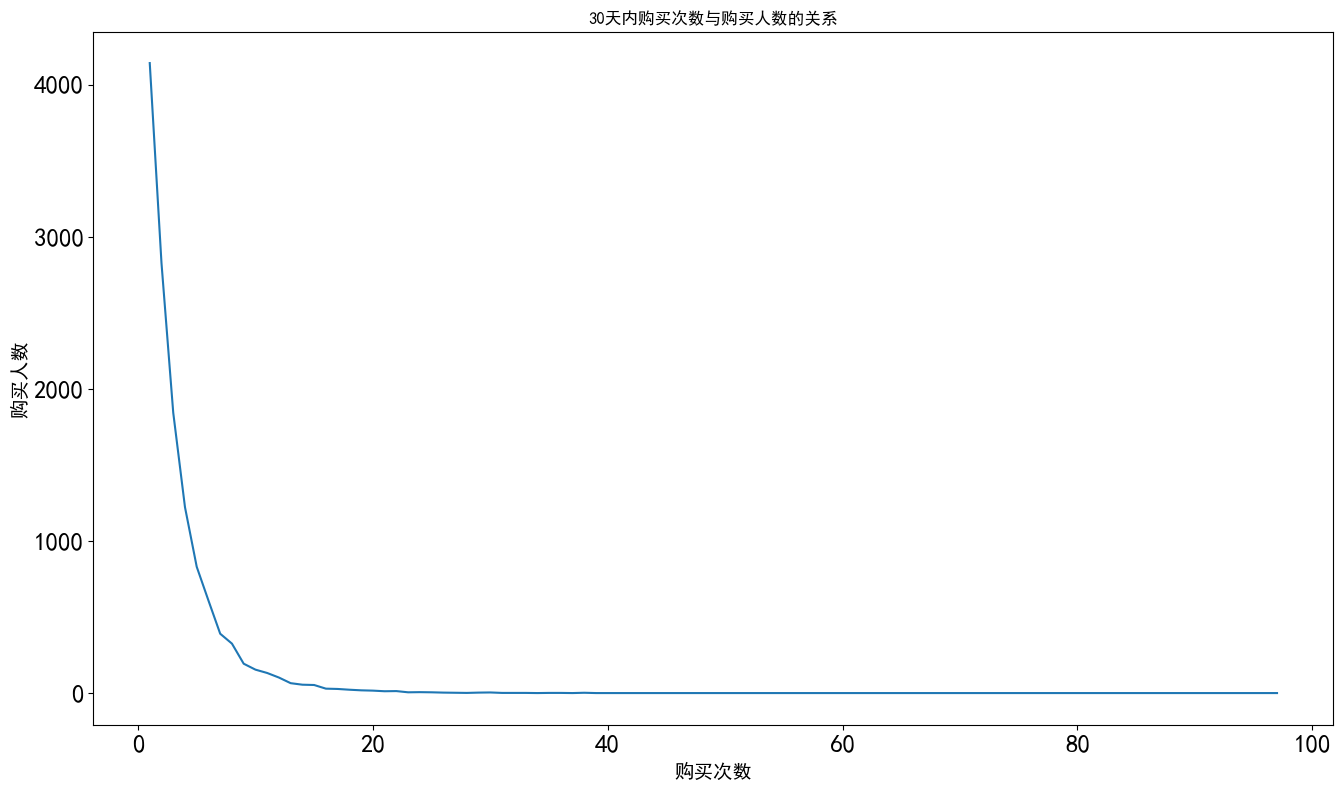

In [122]:
buy_active_level = labels['counts_30_buy'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16,9))
buy_active_level.plot(title='30天内购买次数与购买人数的关系',fontsize=18)
plt.ylabel('购买人数',fontsize=14)
plt.xlabel('购买次数',fontsize=14)
labels['buy_active_level'] = '高'
labels.loc[labels['counts_30_buy']<=14,'buy_active_level'] = '低'

由图可知，14次左右是个拐点，因此定义购买次数小于等于14次的用户为低活跃用户，大于14次的用户为高活跃用户。

#### 5.4 购买的品类是否单一

In [123]:
buy_single=df[df['behavior_type']==4].groupby('user_id').item_category.nunique().reset_index()
buy_single.rename(columns={'item_category':'buy_single'},inplace=True)
labels = pd.merge(labels,buy_single,how='left',on='user_id')
labels['buy_single'].fillna(-1,inplace=True)
labels['buy_single'] = labels['buy_single'].apply(lambda x: '是' if x>1 else  '否' if x==1 else '未购买' )

In [124]:
labels

,user_id,time_browse,cate_most_browse,counts_30_buy,counts_30_cart,counts_30_active,days_browse,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single
0,32363170,凌晨,13230,1.0,90.0,31,1.0,31.0,NaN,是,是,否,高,低,否
1,141137969,凌晨,11279,14.0,11.0,24,1.0,1.0,7.0,是,是,是,高,低,是
2,43531769,晚上,10314,1.0,5.0,30,1.0,17.0,NaN,是,是,否,高,低,否
3,49776801,晚上,1863,57.0,20.0,26,1.0,2.0,2.0,是,是,是,高,高,是
4,128031111,晚上,11279,2.0,NaN,27,1.0,11.0,8.0,是,否,是,高,低,是
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19942,16783114,中午,1488,NaN,NaN,1,19.0,NaN,NaN,是,否,未购买,低,高,未购买
19943,135594252,晚上,8161,NaN,NaN,1,24.0,NaN,NaN,是,否,未购买,低,高,未购买
19944,139786090,下午,12553,NaN,NaN,1,23.0,NaN,NaN,是,否,未购买,低,高,未购买
19945,108201638,晚上,6648,NaN,NaN,1,3.0,NaN,NaN,是,否,未购买,低,高,未购买


了解用户购买的品类有利于构建用户群体行为，比如该群体统一对化妆品消费占比巨大，则该用户群体的主要特征标签之一就是化妆品。

#### 5.5 用户价值分组（RFM模型）

Text(0.5, 0, '距今天数')

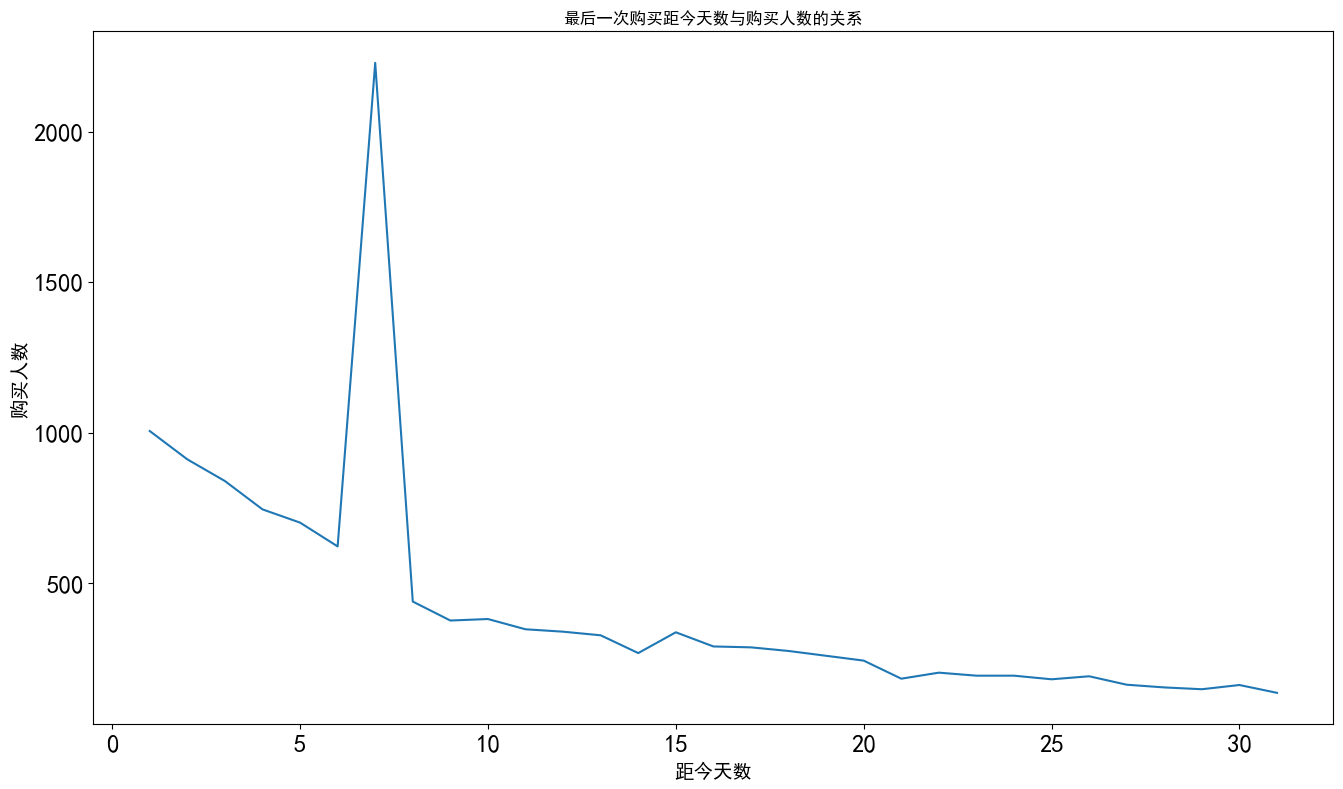

In [127]:
last_buy_days = labels['days_buy'].value_counts().sort_index()
plt.figure(figsize=(16,9))
last_buy_days.plot(title='最后一次购买距今天数与购买人数的关系',fontsize=18)
plt.ylabel('购买人数',fontsize=14)
plt.xlabel('距今天数',fontsize=14)

使用RFM模型分析：

In [128]:
labels['buy_days_level'] = '高'
labels.loc[labels['days_buy']>8,'buy_days_level'] = '低'
labels['rfm_value'] = labels['buy_active_level'].str.cat(labels['buy_days_level'])
def trans_value(x):
    if x == '高高':
        return '重要价值客户'
    elif x == '低高':
        return '重要深耕客户'
    elif x == '高低':
        return '重要唤回客户'
    else: 
        return '即将流失客户'
labels['rfm'] = labels['rfm_value'].apply(trans_value)
# 此处的apply()调用了一个自己定义（def）的函数
labels.drop(['buy_days_level','rfm_value'],axis=1,inplace=True)
labels['rfm'].value_counts()

rfm
重要深耕客户    7255
重要价值客户    7033
即将流失客户    5645
重要唤回客户      14
Name: count, dtype: int64

str.cat()是指将两个独立的字符串拼接，此处将
'buy_active_level‘和'buy_days_level'拼接。
如果要在两个合并的列中间加一个分隔符号，可在cat括号内加：sep='-'，用-连接合并内容。

将buy_active_level和buy_days_level组合，形成“高高”或者“高低”等。将两个重要指标合并后，每个user_id进入不同的分类组。

RFM模型是衡量客户价值和客户创利能力的重要工具和手段，其中，R(recently)：最近一次消费；F（Frequently）：消费频率；M（Monetary）：消费金额。



### 6. 总结

对最后输出的用户群体制定不同的营销策略。针对重要价值客户要予以关注并维护；针对重要深耕用户，予以相应的价格刺激，如折扣和捆绑销售等增加用户的购买频率，提高黏性；针对重要唤回用户，要在特定时间点进行刺激，比如进行产品卖点刺激、品牌灌输等，不断加强他们对品牌的认可，提高忠诚度；针对流失客户，在此例中，因其数量占三分之一左右，需进一步分析得出流失原因。